### Initialization
Installing requirements, auto reload changing to code and imports

In [12]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import dice_ml

import multiprocessing

from copy import deepcopy

import time

import json

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

### Define research parameters

In [15]:
regression_task = False
continuous_features = ['Age', 'Credit amount', 'Duration']
metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
test_size_proportion = 0.33
augment_sample = 0.5

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random', 'kw_args': {'total_CFs': 10}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 7, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 7, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2,
                                         'total_CFs': 10}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [16]:
raw_data = pd.read_csv(r"../datasets/german_credit.csv", index_col=0)
df = utils.preprocess_german(raw_data)
target = 'Risk'

#### split data

In [17]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [18]:
display(y_train.value_counts())

1    471
0    199
Name: Risk, dtype: int64

In [19]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [20]:
print(f'whole adult dataset scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
whole_dataset_result_df

whole adult dataset scores:


whole                                        
           f1  accuracy precision    recall   roc_auc
lg   0.823529  0.727273  0.764925  0.943231  0.745212
rf   0.822669  0.706061  0.707547  1.000000  0.755502
xgb  0.815109  0.718182  0.748175  0.960699  0.766267

In [21]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [22]:
from data_augmentaion.data_augmentator import DataAugmentor 

In [23]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])


    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 8.537981748580933 seconds for settings 0
2 / 4, {'method': 'smote'} 9.357495784759521 seconds for settings 1
3 / 4, {'method': 'cf_random', 'kw_args': {'total_CFs': 10}} model for cf f1 score: {'cf': {'f1': 0.82}}
0/272


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


50/272


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


100/272


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


150/272


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


200/272


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


250/272


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


model for cf f1 score: {'cf': {'f1': 0.82}}
0/335


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


50/335


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


100/335


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


150/335


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


200/335


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


250/335


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


300/335


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


140.79567432403564 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2, 'total_CFs': 10}} model for cf f1 score: {'cf': {'f1': 0.82}}
0/272


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


50/272


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


100/272


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


150/272


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


200/272


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


250/272


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


model for cf f1 score: {'cf': {'f1': 0.82}}
0/335


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


291.2127420902252 seconds for settings 3

Total time: 449.9038939476013


# summary

In [24]:
full_results_df

whole                                         random balanced  \
           f1  accuracy precision    recall   roc_auc              f1   
lg   0.823529  0.727273  0.764925  0.943231  0.745212        0.759259   
rf   0.822669  0.706061  0.707547  1.000000  0.755502        0.775414   
xgb  0.815109  0.718182  0.748175  0.960699  0.766267        0.788546   

                                               random                      \
     accuracy precision    recall   roc_auc        f1  accuracy precision   
lg   0.684848  0.807882  0.711790  0.739850  0.827038  0.736364  0.759124   
rf   0.712121  0.841837  0.716157  0.758680  0.824399  0.712121  0.714744   
xgb  0.718182  0.809091  0.781659  0.737775  0.826347  0.736364  0.761029   

                        smote balanced                                \
       recall   roc_auc             f1  accuracy precision    recall   
lg   0.938865  0.752432       0.785219  0.718182  0.825871  0.742358   
rf   0.991266  0.754118       0.791946  0.718182  0.811927  0.772926   
xgb  0.908297  0.748843       0.812362  0.742424  0.821429  0.799127   

                  smote                                          \
      roc_auc        f1  accuracy precision    recall   roc_auc   
lg   0.749276  0.785219  0.718182  0.825871  0.742358  0.749276   
rf   0.769770  0.791946  0.718182  0.811927  0.772926  0.769770   
xgb  0.762506  0.812362  0.742424  0.821429  0.799127  0.762506   

    cf_random balanced                                         cf_random  \
                    f1  accuracy precision    recall   roc_auc        f1   
lg            0.774775  0.696970  0.800000  0.751092  0.741753  0.776256   
rf            0.773455  0.700000  0.812500  0.733624  0.744044  0.771363   
xgb           0.814655  0.739394  0.804255  0.825328  0.756215  0.813043   

                                            cf_genetic balanced            \
     accuracy precision    recall   roc_auc                  f1  accuracy   
lg   0.703030  0.813397  0.742358  0.742920            0.766744  0.693939   
rf   0.681818  0.818627  0.689956  0.745860            0.765550  0.703030   
xgb  0.739394  0.809524  0.799127  0.751589            0.790287  0.718182   

                                  cf_genetic                                \
    precision    recall   roc_auc         f1  accuracy precision    recall   
lg   0.813725  0.729258  0.735008   0.766055  0.675758  0.796117  0.729258   
rf   0.846561  0.711790  0.755264   0.764846  0.700000  0.850000  0.703057   
xgb  0.806306  0.781659  0.752778   0.795604  0.718182  0.800885  0.799127   

               
      roc_auc  
lg   0.725712  
rf   0.749687  
xgb  0.753145

In [25]:
print('best methods')
best_methods = pd.DataFrame()
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    max_models = models_scores.idxmax(axis='columns')
    max_models.name = s
    max_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)
    best_methods = pd.concat([best_methods, max_models], axis=1)
best_methods

best methods


,f1,accuracy,precision,recall,roc_auc
lg,random,random,smote balanced,whole,random
rf,random,smote balanced,cf_genetic,whole,smote balanced
xgb,random,smote balanced,smote balanced,whole,whole
overall,random,smote balanced,cf_genetic,whole,smote balanced


In [26]:
full_results_df.to_csv(rf'../log/experiment_german.csv')

In [27]:
methods_scores = {}
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    methods_scores[s] = models_scores

In [28]:
float_format = "{:0.4f}".format
for metric, df in methods_scores.items():
    latex = df.to_latex(float_format=float_format, index=False)
    latex = latex.replace('\\toprule', '').replace('\\midrule', '').replace('\\bottomrule', '')
    latex = latex.split('\n')
    latex.insert(1, '\\toprule')
    latex.insert(4, '\\midrule')
    latex.insert(-2, '\\bottomrule')
    latex = '\n'.join(latex)

    
    # Write the LaTeX table to a file
    with open(f'../graphs/german/latex/german_{metric}_table.tex', 'w') as f:
        f.write(latex)

C:\Users\danie\AppData\Local\Temp\ipykernel_34548\468028345.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(float_format=float_format, index=False)


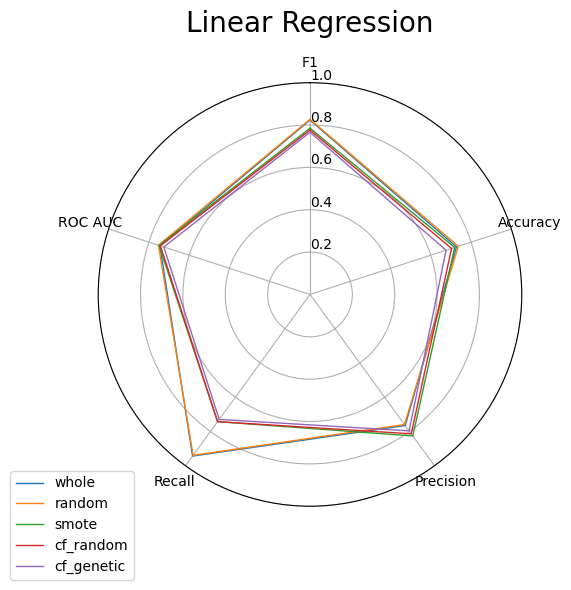

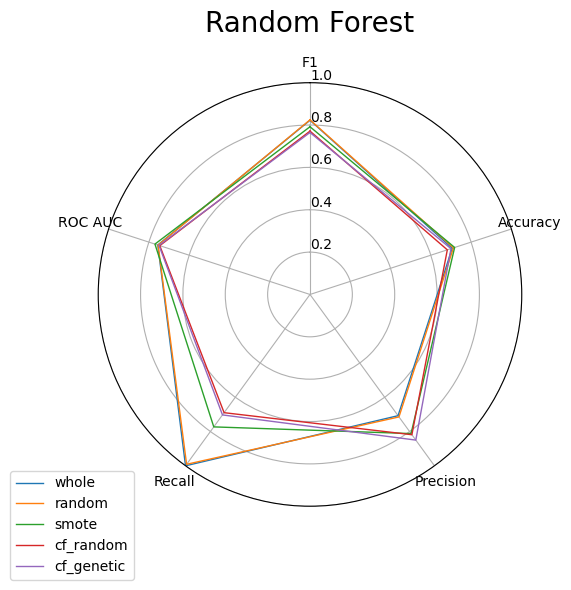

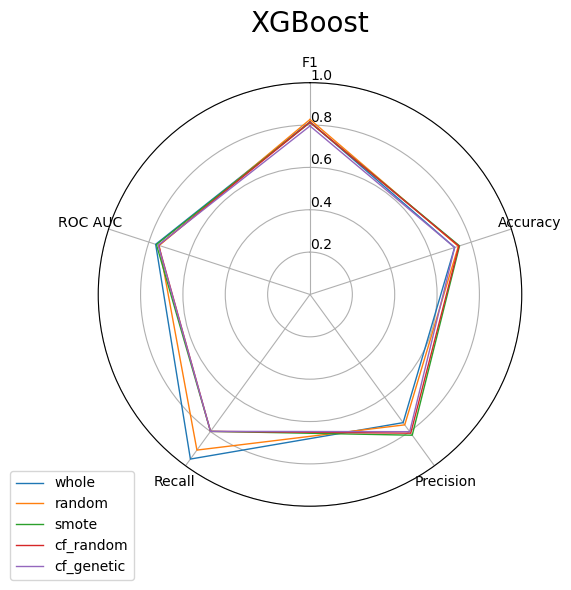

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the list of models
models = list(next(iter(methods_scores.values())).index)
# Number of variables (i.e., number of metrics)
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = ['F1', 'Accuracy', 'Precision', 'Recall','ROC AUC']  

num_vars = len(methods_scores)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a full circle
angles += angles[:1]
def plot_spider(df, idx=0, title='Spider plot'):
    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Makes sure the First metric is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metric_names)
    ax.set_rlabel_position(0)
    plt.ylim(0, 1)
    # print(df.iloc[0])
    values = []
    labels = df.columns
    for _, df in methods_scores.items(): 
        df2 = df[wanted_cols]
        values.append(df2.iloc[idx])
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=wanted_cols)
    # ax.fill(angles,values, alpha=0.1)


    # Add legend
    plt.title(title, size=20, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../graphs/german/{title}.png')

plot_spider(df, idx=0, title='Linear Regression')
plot_spider(df, idx=1, title='Random Forest')
plot_spider(df, idx=2, title='XGBoost')